In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
from copy import deepcopy
import geopandas as gpd
import geopy

## Step 0 set up the data root path and load network data

In [2]:
network_root_path = os.path.join(os.getcwd(), 'UKM_PrimarySubstation_Data')

SSEN = os.path.join(network_root_path, 'SSEN')
UKPN = os.path.join(network_root_path, 'UK Power Networks')
WPD = os.path.join(network_root_path, 'Western Power Distribution')
ENW = os.path.join(network_root_path, 'Electricity Northwest')
NPG = os.path.join(network_root_path, 'NorthernPowergrid')
SPEN = os.path.join(network_root_path, 'SPEN')

# ukpn is for primary substation only
ukpn = pd.read_csv(os.path.join(UKPN, 'ukpn_primary_postcode_area.csv'))
ukpn["PrimarySu"] = ukpn["PrimarySu"].str.split(" ").str[:-1].str.join(" ")

# enw is for primary substation only
enw = pd.read_excel(os.path.join(ENW, 'table-3---load-data.xlsx'), header=[3], sheet_name = "Pry Load Table")
# drop those with nan ps name. those are not data entries but remarks
enw = enw[~enw.iloc[:,1].isna()]
# enw has duplicated PS names (col 1), so we need to drop them (only 2, and they are validated to be exactly the same PS)
enw.drop_duplicates(subset=["Substation or Busbar Name"], keep="first", inplace=True, ignore_index=True)

# npg data has Primary substation indicator, we select PS only
npg_ne = pd.read_excel(os.path.join(NPG, 'network.xlsx'), sheet_name="Northeast Demand", header=[0,1,2,3,4])
npg_ne = npg_ne[npg_ne.iloc[:,-1].str.contains("rimary")]

npg_york = pd.read_excel(os.path.join(NPG, 'network.xlsx'), sheet_name="Yorkshire Demand", header=[0,1,2,3,4])
npg_york = npg_york[npg_york.iloc[:,-1].str.contains("rimary")]

# spen is for primary substation only
spd = pd.read_excel(os.path.join(SPEN, 'SPD LTDS 2023 Appendix 3 System Loads (Table 3).xlsx'), header=[2,3])
spm = pd.read_excel(os.path.join(SPEN, 'Appendix 3 System Loads (Table 3) SPM 2023.xlsx'), sheet_name="Table 3 - System Loads_HV", header=[2,3,4])
# for spm, enumerate the first column (PS group name) to fill NAs as the PS group name only appears for the first PS in a PS group.
# this did not happen for spm datasheet in 2022...
spm.iloc[:,0] = spm.iloc[:,0].fillna(method='ffill')

# ssen is for primary substation only
SEPD = pd.read_excel(os.path.join(SSEN, "sepd-network-headroom-report.xlsx"), sheet_name="Primary Headroom Dem", header=[0,1])
SEPD = SEPD[SEPD.iloc[:,4] == "MINIMUM HEADROOM"]
SEPD = pd.concat([SEPD.iloc[:,3].str.lower(), SEPD["Demand Headroom Winter MVA"][2023]], axis=1)
SEPD = pd.DataFrame(data = SEPD.values, columns=["PS Name", "Demand Headroom (MVA)"])

SHEPD = pd.read_excel(os.path.join(SSEN, "shepd-network-headroom-report.xlsx"), sheet_name="Primary Headroom Dem", header=[0,1])
SHEPD = SHEPD[SHEPD.iloc[:,3] == "MINIMUM HEADROOM"]
SHEPD = pd.concat([SHEPD.iloc[:,2].str.lower(), SHEPD["Demand Headroom Winter MVA"][2023]], axis=1)
SHEPD = pd.DataFrame(data = SHEPD.values, columns=["PS Name", "Demand Headroom (MVA)"])

ssen = pd.concat([SEPD, SHEPD], axis = 0)
del SEPD
del SHEPD

# load WPD data
wpd = pd.read_csv(os.path.join(WPD, "WPD Geo and Network Capacity Map 28-02-2023.csv"))
# select PS
wpd = wpd[wpd["Asset Type"] == "Primary"]

In [3]:
# SPM (a part of SPEN) data needs to be processed. The firm capacity in SPM is for the whole PS groups instead of a single PS
# therefore, we need to sum the (net) demand and Q for each PS group
# note that SPM source data provides two cols of demand, i.e., Maximum Load (MW) and Maximum Load (MVA(1)). The former is for individual PS and the latter is for the whole PS group. However, as stated in the note (1) of the data file, Maximum Load (MVA(1)) refers to the gross demand, which is the maximum demand increased by measured distribution generation. Therefore, we will use the Maximum Load (MW) as the net demand.
spm_process = pd.DataFrame([])
spm_process['PSname'] = spm.iloc[:,0]
spm_process['Demand (MW)'] = pd.to_numeric(spm.iloc[:,3], errors='coerce')
spm_process['Q (MVar)'] = pd.to_numeric(spm.iloc[:,4], errors='coerce')
spm_process = spm_process.groupby("PSname").sum(min_count=1)
spm_process["PSname"] = spm_process.index.tolist()
# power factor (PF) is the ratio of real power to apparent power
spm_process['PF'] = spm_process['Demand (MW)'].values / np.sqrt(spm_process['Demand (MW)'].values**2 + spm_process['Q (MVar)'].values**2)

firm_cap_list = []
for ps_name in spm_process["PSname"].tolist():
    firm_cap_list.append(pd.to_numeric(spm[spm.iloc[:,0] == ps_name].iloc[0,-3], errors='coerce'))

spm_process["FirmCap (MVA)"] = firm_cap_list

In [4]:
UKM_PS_no_tot = len(ssen) + len(spm_process) + len(spd) + len(ukpn) + len(wpd) + len(enw) + len(npg_ne) + len(npg_york)
print(f'The total number of PSs in UKM is {UKM_PS_no_tot}')

The total number of PSs in UKM is 4339


## Step 1. process and combine information for each of the UK DNOs.

In [5]:
# define function for coordinate transformation
from pyproj import Transformer, CRS

def UK_to_lonlat(east, north):
    # 4326 is the long, lat system while 27700 is the coordinates specified in the .proj file or read from geodf.crs
    # this convert the location under UK map coordinate to lat, lon format
    des_crs = CRS('EPSG:4326')
    src_crs = CRS('EPSG:27700')
    transformer = Transformer.from_crs(src_crs, des_crs, always_xy=True)
    # Convert the coordinate to the destination projection system
    lon, lat = transformer.transform(east, north)
    return lat, lon

In [6]:
# define function to process the PS name to facilicate the matching between different datasets
def process_PS_name(df, col_name = "PS Name"):
    # lower case
    df[col_name] = df[col_name].str.lower()
    # remove the last str "xkV"
    df[col_name] = df[col_name].str.replace(r'$ \d+kv', '', regex=True)
    # remove space at the start and end
    df[col_name] = df[col_name].str.strip()
    return df

In [7]:
# some DNOs do not have power factors, so we will assume a typical value
# the typical value is the average of the power factor of the other DNOs (ENW and SPEN)
Assumed_PF_list = np.abs(np.hstack([enw.iloc[:,4].copy().values, spd.iloc[:, 5].copy().values, spm_process["PF"].copy().values]))
Assumed_PF = np.nanmean(Assumed_PF_list)
Assumed_PF

0.9889836133434563

In [8]:
# print the 1% and 5% quant
print("1% percentile of all PFs:", np.nanpercentile(Assumed_PF_list, 1))
print("5% percentile of all PFs:", np.nanpercentile(Assumed_PF_list, 5))

1% percentile of all PFs: 0.8618901419797546
5% percentile of all PFs: 0.9500008449295589


95% PFs are greater than 0.95. It therefore seems reasonable to assume an average PF at 0.989 due to the high concentration.

### ENW

In [9]:
# based on long-term-development-statement.pdf Section 4.2.3.1, the demand has been adjusted to take into account the generation contribution
# the information collected is for year 2022/23
ENW_df = pd.DataFrame(data = enw.iloc[:, [1, -3, 3, 4]].copy().values, columns=["PS Name", "Firm Capacity (MVA)", "Demand (MVA)", "PF"])
ENW_df = process_PS_name(ENW_df)
ENW_df

,PS Name,Firm Capacity (MVA),Demand (MVA),PF
0,albion st,22.863,11.720532,0.998712
1,alderley & chelford,28.31,17.003134,0.9756
2,alston,1.7,1.531605,0.985752
3,ambleside,17.8,9.192532,0.993175
4,ancoats north t11 & t12,22.863,17.347102,0.992857
...,...,...,...,...
363,woolfold,23.0,10.612275,0.991375
364,wordsworth st,22.863,12.945132,0.999165
365,worsley mesnes,22.863,8.390747,0.995139
366,wrightington,22.863,10.709691,0.984961


In [10]:
# the geo location and the upper-level GSP info is stored in a separate file
ENW_geo_df = pd.DataFrame(data = pd.read_excel(os.path.join(ENW, "PS-LA.xlsx"), sheet_name="Primary Headroom", header=[6,7]).iloc[:,[1, -4,-3, -1]].values, columns=["PS Name", "Easting", "Northing", "GSP"])

# process the PS name
ENW_geo_df = process_PS_name(ENW_geo_df)

ENW_geo_df.dropna(inplace=True)
# project the easting and northing to long, lat
geo_list = []
for i, subdf in ENW_geo_df.iterrows():
    lat, lon = UK_to_lonlat(east = subdf["Easting"], north = subdf["Northing"])
    geo_list.append(f"{lon},{lat}")
ENW_geo_df["Geo(Long,Lat)"] = geo_list

ENW_geo_df.reset_index(inplace=True, drop = True)

ENW_geo_df.drop(columns=["Easting", "Northing"], inplace=True)
ENW_geo_df

,PS Name,GSP,"Geo(Long,Lat)"
0,albion st,ROCHDALE,"-2.4950937454916797,53.73015403195597"
1,alderley & chelford,SOUTH MANCHESTER,"-2.225911796847622,53.30796142675533"
2,alston,HUTTON,"-2.4352546655219385,54.81256830516162"
3,ambleside,HUTTON,"-2.963194161426022,54.42314157846089"
4,ancoats north t11 & t12,WHITEGATE,"-2.2271891138444646,53.485968874301655"
...,...,...,...
360,woolfold,KEARSLEY,"-2.3207106475600914,53.60112917451506"
361,wordsworth st,KEARSLEY,"-2.4440146735255985,53.59360718447577"
362,worsley mesnes,KIRKBY,"-2.643610708764175,53.5307151030593"
363,wrightington,PENWORTHAM,"-2.7048739300119315,53.6140793967929"


#### now try to merge them together

In [11]:
geo_list = []
gsp_list = []

for idx, row in ENW_df.iterrows():
    # enumerate the PS name
    ps_name = row["PS Name"]
    # find the region information
    for j in range(len(ps_name)):
        # drop the last char
        ps_name_l = ps_name[:len(ps_name)-j]
        # find match
        matched_df = ENW_geo_df[ENW_geo_df["PS Name"] == ps_name_l]

        if (len(matched_df) > 0):
            if j >= 1:
                # if the search is successful only after chracter reduction, print the information so we can manually check if the match makes sense
                print(f"PS {ps_name}, reduced PS name is {ps_name_l}, the matched ps name is {matched_df['PS Name']}")
            # match found, break the loop
            break
    if j == (len(ps_name)-1):
        # no match is found successfully,
        # print the following information so we may manually check again if this PS is indeed not found
        print(f"PS match fails, we try to match {ps_name}")
        geo_list.append(float('nan'))
        gsp_list.append(float('nan'))
    else:
        geo_list.append(matched_df.iloc[0]["Geo(Long,Lat)"])
        gsp_list.append(matched_df.iloc[0]["GSP"])


ENW_df['Geo(Long,Lat)'] = geo_list
ENW_df['GSP'] = gsp_list

'''
among the 368 PSs, only 4 entries are not found, so I think it's safe to drop na (except RegCode)
'''

ENW_df.dropna(subset = ["PS Name", "Firm Capacity (MVA)", "Demand (MVA)", "PF", "GSP"], inplace=True)

# del ENW_geo_df
ENW_df

PS circle square, reduced PS name is circle sq, the matched ps name is 82    circle sq
Name: PS Name, dtype: object
PS match fails, we try to match manchester university
PS match fails, we try to match samlesbury enterprise zone
PS match fails, we try to match st johns
PS match fails, we try to match thorley lane


,PS Name,Firm Capacity (MVA),Demand (MVA),PF,"Geo(Long,Lat)",GSP
0,albion st,22.863,11.720532,0.998712,"-2.4950937454916797,53.73015403195597",ROCHDALE
1,alderley & chelford,28.31,17.003134,0.9756,"-2.225911796847622,53.30796142675533",SOUTH MANCHESTER
2,alston,1.7,1.531605,0.985752,"-2.4352546655219385,54.81256830516162",HUTTON
3,ambleside,17.8,9.192532,0.993175,"-2.963194161426022,54.42314157846089",HUTTON
4,ancoats north t11 & t12,22.863,17.347102,0.992857,"-2.2271891138444646,53.485968874301655",WHITEGATE
...,...,...,...,...,...,...
363,woolfold,23.0,10.612275,0.991375,"-2.3207106475600914,53.60112917451506",KEARSLEY
364,wordsworth st,22.863,12.945132,0.999165,"-2.4440146735255985,53.59360718447577",KEARSLEY
365,worsley mesnes,22.863,8.390747,0.995139,"-2.643610708764175,53.5307151030593",KIRKBY
366,wrightington,22.863,10.709691,0.984961,"-2.7048739300119315,53.6140793967929",PENWORTHAM


### NPG


In [12]:
# as can be observed in the "Glossary" sheet, the demand is the net demand (after offsetting the local generation)
NPG_df = pd.DataFrame(data = np.hstack([np.vstack([npg_ne.iloc[:,[1, 5, 6]].values, npg_york.iloc[:,[1, 5, 6]].values]), float('nan')*np.ones([len(npg_ne)+len(npg_york), 1])]), columns = ["PS Name", "Firm Capacity (MVA)", "Demand (MVA)", "PF"])
# process the PS name
NPG_df = process_PS_name(NPG_df)
NPG_df

,PS Name,Firm Capacity (MVA),Demand (MVA),PF
0,foss islands,36,27.62608,NaN
1,oatlands,22.9,9.796203,NaN
2,starbeck,22.9,20.159617,NaN
3,barden friar,5,0.9375,NaN
4,bedale,22,17.549979,NaN
...,...,...,...,...
530,hessle road 2,23.0,10.678724,NaN
531,elmhirst lane 2,24.0,11.560354,NaN
532,allerton hill t2,23.0,7.211664,NaN
533,newport 2,18.4,5.880708,NaN


In [13]:
# load longlat data
NPG_geo_df = pd.read_csv(os.path.join(NPG, "npg_ndp_demand_headroom.csv"))
NPG_geo_df = NPG_geo_df[NPG_geo_df['Bulk Supply Point or Primary'] == 'Primary'].drop_duplicates(subset=['Substation Name'])[['Substation Name', 'location', 'GSP']].reset_index(drop = True)
NPG_geo_df = NPG_geo_df.rename(columns={'Substation Name':'PS Name', 'location':'LatLong'})
# process the PS name
NPG_geo_df = process_PS_name(NPG_geo_df)

# manually match some PS names. Those have been listed and justified in our paper
inter = NPG_geo_df.loc[NPG_geo_df["PS Name"]=="boroughbridge/roecliffe industrial"].copy()
NPG_geo_df.loc[NPG_geo_df["PS Name"]=="boroughbridge/roecliffe industrial", "PS Name"] = "boroughbridge"
NPG_geo_df = NPG_geo_df.append(inter,ignore_index=True)
NPG_geo_df.loc[NPG_geo_df["PS Name"]=="boroughbridge/roecliffe industrial", "PS Name"] = "roecliffe industrial"

inter = NPG_geo_df.loc[NPG_geo_df["PS Name"]=="sessay bridge_sowerby"].copy()
NPG_geo_df.loc[NPG_geo_df["PS Name"]=="sessay bridge_sowerby", "PS Name"] = "sessay bridge"
NPG_geo_df = NPG_geo_df.append(inter,ignore_index=True)
NPG_geo_df.loc[NPG_geo_df["PS Name"]=="sessay bridge_sowerby", "PS Name"] = "sowerby"

inter = NPG_geo_df.loc[NPG_geo_df["PS Name"]=="fawdon t1 & seaton burn t1"].copy()
NPG_geo_df.loc[NPG_geo_df["PS Name"]=="fawdon t1 & seaton burn t1", "PS Name"] = "fawdon t1"
NPG_geo_df = NPG_geo_df.append(inter,ignore_index=True)
NPG_geo_df.loc[NPG_geo_df["PS Name"]=="fawdon t1 & seaton burn t1", "PS Name"] = "seaton burn t1"

NPG_geo_df.loc[NPG_geo_df["PS Name"]=="mansfield road 1", "PS Name"] = "mansfield road"

NPG_geo_df.reset_index(drop = True, inplace = True)
NPG_geo_df

C:\Users\Zhou_Ming\AppData\Local\Temp\ipykernel_157904\3563885823.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  NPG_geo_df = NPG_geo_df.append(inter,ignore_index=True)
C:\Users\Zhou_Ming\AppData\Local\Temp\ipykernel_157904\3563885823.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  NPG_geo_df = NPG_geo_df.append(inter,ignore_index=True)
C:\Users\Zhou_Ming\AppData\Local\Temp\ipykernel_157904\3563885823.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  NPG_geo_df = NPG_geo_df.append(inter,ignore_index=True)


,PS Name,LatLong,GSP
0,allerton hill t1,"53.83067136628643, -1.5391248216660285",SKELTON GRANGE
1,armouries drive,"53.79066605340524, -1.5299547014623773",SKELTON GRANGE
2,askern,"53.61891593835856, -1.1596496050358693",WEST MELTON / THORPE MARSH
3,bailiff bridge,"53.721283724071434, -1.7781209881237274",ELLAND
4,balme street,"53.79740881482084, -1.7489355307965837",BRADFORD WEST
...,...,...,...
543,usworth,"54.91627262511623, -1.49690612038587",WEST BOLDON
544,whitby west t1,"54.4801062849319, -0.6352342462916933",OSBALDWICK
545,roecliffe industrial,"54.08706163572902, -1.4140068681468814",KNARESBOROUGH
546,sowerby,"54.174139097805714, -1.3193130759959464",KNARESBOROUGH


In [14]:
# convert the geo information to our standard format
geo_list = []

for item in NPG_geo_df["LatLong"]:
    if item != item:
        geo_list.append(float('nan'))
        continue

    lat, lon = item.replace(' ', '').split(',')

    geo_list.append(','.join([lon, lat]))

NPG_geo_df["Geo(Long,Lat)"] = geo_list

NPG_geo_df.dropna(inplace=True)

NPG_geo_df.reset_index(inplace=True, drop = True)
NPG_geo_df.drop(columns=["LatLong"], inplace = True)
NPG_geo_df

,PS Name,GSP,"Geo(Long,Lat)"
0,allerton hill t1,SKELTON GRANGE,"-1.5391248216660285,53.83067136628643"
1,armouries drive,SKELTON GRANGE,"-1.5299547014623773,53.79066605340524"
2,askern,WEST MELTON / THORPE MARSH,"-1.1596496050358693,53.61891593835856"
3,bailiff bridge,ELLAND,"-1.7781209881237274,53.721283724071434"
4,balme street,BRADFORD WEST,"-1.7489355307965837,53.79740881482084"
...,...,...,...
543,usworth,WEST BOLDON,"-1.49690612038587,54.91627262511623"
544,whitby west t1,OSBALDWICK,"-0.6352342462916933,54.4801062849319"
545,roecliffe industrial,KNARESBOROUGH,"-1.4140068681468814,54.08706163572902"
546,sowerby,KNARESBOROUGH,"-1.3193130759959464,54.174139097805714"


#### Now we merge all these to create the final NPG df

In [15]:
gsp_list = []
geo_list = []

# the process is exactly the same as ENW, see the comments there
for idx, row in NPG_df.iterrows():
    ps_name = row["PS Name"]
    for j in range(len(ps_name)):
        ps_name_l = ps_name[:len(ps_name)-j]
        matched_df = NPG_geo_df[NPG_geo_df["PS Name"] == ps_name_l]

        if (len(matched_df) > 0):
            if j >= 1:
                print(f"PS {ps_name}, reduced PS name is {ps_name_l}, the matched ps name is {matched_df['PS Name']}")
            break
    if j == (len(ps_name)-1):
        print(f"PS match fails, we try to match {ps_name}")
        gsp_list.append(float("nan"))
        geo_list.append(float('nan'))
    else:
        gsp_list.append(matched_df.iloc[0]["GSP"])
        geo_list.append(matched_df.iloc[0]["Geo(Long,Lat)"])


NPG_df["GSP"] = gsp_list
NPG_df['Geo(Long,Lat)'] = geo_list

NPG_df.reset_index(inplace=True, drop=True)
NPG_geo_df.reset_index(inplace=True, drop=True)

'''
among the 535 PSs in NPG_df, only 3 entries are not found, so I think it's safe to drop na (except RegName)
'''

NPG_df.dropna(subset = ["PS Name", "Firm Capacity (MVA)", "Demand (MVA)", 'Geo(Long,Lat)', 'GSP'], inplace=True)

del NPG_geo_df
NPG_df

PS match fails, we try to match ottringham road
PS match fails, we try to match grimsby docks
PS match fails, we try to match yorkshire water hull road


,PS Name,Firm Capacity (MVA),Demand (MVA),PF,GSP,"Geo(Long,Lat)"
0,foss islands,36,27.62608,NaN,OSBALDWICK,"-1.072350544977576,53.96130167104259"
1,oatlands,22.9,9.796203,NaN,KNARESBOROUGH,"-1.5312933789448784,53.97683801648599"
2,starbeck,22.9,20.159617,NaN,KNARESBOROUGH,"-1.4986354355284524,53.99709055320108"
3,barden friar,5,0.9375,NaN,NORTON,"-1.7945973888652424,54.3377382553703"
4,bedale,22,17.549979,NaN,NORTON,"-1.5905305713519269,54.29018855270453"
...,...,...,...,...,...,...
530,hessle road 2,23.0,10.678724,NaN,CREYKE BECK,"-0.39596539123283914,53.72899355952191"
531,elmhirst lane 2,24.0,11.560354,NaN,WEST MELTON SECTION 3,"-1.5384212769097723,53.54709973549783"
532,allerton hill t2,23.0,7.211664,NaN,SKELTON GRANGE,"-1.5391248216660285,53.83067136628643"
533,newport 2,18.4,5.880708,NaN,DRAX,"-0.6970210255821523,53.76591223391769"


### Now we move to SPEN 

In [16]:
# spd contains the GSP info. However, because of the excel format, the GSP info only apprears for the first PS in a GSP group, so we need to manually fill the GSP info for the rest of the PSs in the same GSP group
for i in range(1, len(spd)):
    if spd.iloc[i, 0] != spd.iloc[i, 0]:
        spd.iloc[i, 0] = spd.iloc[i-1, 0]

# for spm, it does not provide the GSP info and is set to nan
spm_process["GSP"] = np.nan
spd

Grid Supply Point         Substation       Voltage (kV)  \
    Unnamed: 0_level_1 Unnamed: 1_level_1 Unnamed: 2_level_1   
0                  AYR           GLENGALL               11.0   
1                  AYR         HEATHFIELD               11.0   
2                  AYR        MILL STREET               11.0   
3                  AYR         OLD BRIDGE               11.0   
4            BAINSFORD          CALLENDAR               11.0   
..                 ...                ...                ...   
385             WISHAW       LEVEN STREET               11.0   
386             WISHAW          MUIRHOUSE               11.0   
387             WISHAW           OVERTOWN               11.0   
388             WISHAW         STONEHOUSE               11.0   
389             WISHAW     WATLING STREET               11.0   

    Maximum Load of Previous Year                         \
                               MW  Q (Mvar) Power Factor   
0                       12.191656  1.302535     0.994341   
1                        9.427961 -0.867302     0.995795   
2                       15.824987  1.732000     0.994064   
3                        9.652512  0.000000     1.000000   
4                       11.965362  0.411996     0.999408   
..                            ...       ...          ...   
385                      9.217825  0.017493     0.999998   
386                      5.098800  0.147574     0.999581   
387                      7.346304  0.350750     0.998862   
388                      5.428110  0.769450     0.990102   
389                     10.310759 -0.040996     0.999992   

    Forecast Load Information (MVA)                                   \
                            2023/24    2024/25    2025/26    2026/27   
0                         12.000210  12.052899  12.800282  13.490447   
1                          9.325323   9.410957   9.846953  10.190422   
2                         15.674361  15.701066  16.513116  17.048405   
3                          9.391134   9.479083   9.931869  10.324751   
4                         11.753468  11.844259  12.338067  12.700424   
..                              ...        ...        ...        ...   
385                        9.041944   9.080807   9.523303   9.767001   
386                        4.934172   4.997660   5.276328   5.508289   
387                        7.262960   7.367421   7.835139   8.362594   
388                        5.330274   5.233150   5.445247   5.627228   
389                       10.115727  10.338196  11.315123  12.195502   

               Firm Capacity (MVA)  
       2027/28 Unnamed: 11_level_1  
0    14.385008                21.0  
1    10.703395                21.0  
2    17.841333                21.0  
3    10.902222                24.0  
4    13.243821                21.0  
..         ...                 ...  
385  10.160648                24.0  
386   5.867737                10.0  
387   9.001920                21.0  
388   5.925825                 8.0  
389  13.416620                21.0  

[390 rows x 12 columns]

In [17]:
# concat spm and spd data containing the demand, firm capacity, and PF
SPEN_df = pd.DataFrame(data = np.vstack([spd.iloc[:,[0, 1,-1,3,5]], spm_process.iloc[:,[-1, 2,-2,0,3]]]), columns = ["GSP", "PS Name", "Firm Capacity (MVA)", "Demand (MVA)", "PF"])
# drop those with nan demand and firm capacity
SPEN_df.dropna(subset=["Firm Capacity (MVA)", "Demand (MVA)"], inplace=True)
# fill nan PF with the assumed PF
SPEN_df["PF"] = SPEN_df["PF"].fillna(Assumed_PF)
# the original data uses active power for demand, we convert it to apparent power based on the PF
SPEN_df["Demand (MVA)"] = SPEN_df["Demand (MVA)"].astype("float").values / SPEN_df["PF"].astype("float").values

# process the PS name
SPEN_df = process_PS_name(SPEN_df)
SPEN_df.reset_index(inplace=True, drop = True)

SPEN_df

,GSP,PS Name,Firm Capacity (MVA),Demand (MVA),PF
0,AYR,glengall,21.0,12.261039,0.994341
1,AYR,heathfield,21.0,9.467769,0.995795
2,AYR,mill street,21.0,15.919486,0.994064
3,AYR,old bridge,24.0,9.652512,1.000000
4,BAINSFORD,callendar,21.0,11.972453,0.999408
...,...,...,...,...,...
723,NaN,wincham t1,7.5,2.322499,0.996208
724,NaN,wistaston hall t1,7.5,4.384217,0.998150
725,NaN,wrenbury frith t1,4.0,3.221136,0.992794
726,NaN,yockings gate t1,10.0,3.419305,0.999792


In [18]:
# load the datasets containing the information of the PS location
SPM_geo_df = pd.read_excel(os.path.join(SPEN, "SPM.xlsx"))[["PSname", "Geo(Long,Lat)"]]
SPD_geo_df = pd.read_excel(os.path.join(SPEN, "SPD.xlsx"))[["Substation", "Geo(Long,Lat)"]]
SPM_geo_df = SPM_geo_df.rename(columns = {"PSname":"PS Name"})
SPD_geo_df = SPD_geo_df.rename(columns = {"Substation":"PS Name"})

SPEN_geo_df = pd.concat([SPM_geo_df, SPD_geo_df], axis = 0)
# we need tro extract the geo info to a standard format long, lat
SPEN_geo_df["Geo(Long,Lat)"] = SPEN_geo_df["Geo(Long,Lat)"].str.split("[").str[-1].str.replace(' ', '')
SPEN_geo_df.dropna(inplace=True)
# process the PS name
SPEN_geo_df = process_PS_name(SPEN_geo_df)
SPEN_geo_df

,PS Name,"Geo(Long,Lat)"
0,aberdyfi t1,"-4.06,52.545"
1,abergele t1 / pensarn t1,"-3.561,53.275"
2,abersoch t1,"-4.524,52.822"
3,aberystwyth t1 / north rd t1 / parc-y-llyn t1 ...,"-4.0464,52.4118"
4,acer ave t1,"-2.4338,53.1106"
...,...,...
387,leven street,"-3.9912,55.7805"
388,muirhouse,"-3.9696,55.7761"
389,overtown,"-3.9104,55.7575"
390,stonehouse,"-3.9811,55.6958"


In [19]:
# merge the SPEN datasets
geo_list = []

# the process is exactly the same as ENW, see the comments there
for idx, row in SPEN_df.iterrows():
    ps_name = row["PS Name"]
    for j in range(len(ps_name)):
        ps_name_l = ps_name[:len(ps_name)-j]
        matched_df = SPEN_geo_df[SPEN_geo_df["PS Name"] == ps_name_l]

        if (len(matched_df) > 0):
            if j >= 1:
                print(f"PS {ps_name}, reduced PS name is {ps_name_l}, the matched ps name is {matched_df['PS Name']}")
            break
    if j == (len(ps_name)-1):
        print(f"PS match fails, we try to match {ps_name}")
        geo_list.append(float('nan'))
    else:
        geo_list.append(matched_df.iloc[0]["Geo(Long,Lat)"])


SPEN_df['Geo(Long,Lat)'] = geo_list

'''
among the 728 PSs, to 725
'''
SPEN_df.dropna(subset = ["PS Name", "Firm Capacity (MVA)", "Demand (MVA)", "PF", "Geo(Long,Lat)"], inplace=True)

del SPEN_geo_df

SPEN_df

PS match fails, we try to match kingsland
PS match fails, we try to match brd t1
PS match fails, we try to match lostock t1


,GSP,PS Name,Firm Capacity (MVA),Demand (MVA),PF,"Geo(Long,Lat)"
0,AYR,glengall,21.0,12.261039,0.994341,"-4.612,55.433"
1,AYR,heathfield,21.0,9.467769,0.995795,"-4.605,55.480"
2,AYR,mill street,21.0,15.919486,0.994064,"-4.6251,55.4609"
3,AYR,old bridge,24.0,9.652512,1.000000,"-4.5927,55.4765"
4,BAINSFORD,callendar,21.0,11.972453,0.999408,"-3.7806,56.0022"
...,...,...,...,...,...,...
723,NaN,wincham t1,7.5,2.322499,0.996208,"-2.4855,53.2747"
724,NaN,wistaston hall t1,7.5,4.384217,0.998150,"-2.4715,53.0842"
725,NaN,wrenbury frith t1,4.0,3.221136,0.992794,"-2.6361,53.0334"
726,NaN,yockings gate t1,10.0,3.419305,0.999792,"-2.6756,52.9733"


### Now we move to SSEN 

In [20]:
SSEN_df = ssen.copy()
# the following pairs are manually matched and validated, and are listed in our paper
SSEN_df.loc[SSEN_df["PS Name"]=="westpark fergus", "PS Name"] = "west parkfergus"
SSEN_df.loc[SSEN_df["PS Name"]=="friockheim", "PS Name"] = "friokheim"
SSEN_df.loc[SSEN_df["PS Name"]=="airigh-na-brodaig", "PS Name"] = "arigh-na-brodaig"
SSEN_df.loc[SSEN_df["PS Name"]=="tarbert jura", "PS Name"] = "tarbert, jura"
SSEN_df.loc[SSEN_df["PS Name"]=="tarbert loch fyne", "PS Name"] = "tarbert, loch fyne"
SSEN_df.loc[SSEN_df["PS Name"]=="glenetive", "PS Name"] = "glen etive"
SSEN_df.loc[SSEN_df["PS Name"]=="dervaig", "PS Name"] = "dervaig (incl tiree)"
SSEN_df.loc[SSEN_df["PS Name"]=="m v e e", "PS Name"] = "mvee"
SSEN_df.loc[SSEN_df["PS Name"]=="winterbourne kingston", "PS Name"] = "winterborne kingston"

# process the PS name
SSEN_df = process_PS_name(SSEN_df)

SSEN_df.dropna(inplace=True)

SSEN_df

,PS Name,Demand Headroom (MVA)
0,alderney,8.220754
1,aldershot,5.828561
2,alderton,0.158766
3,alresford,-0.075136
4,alton local,19.265346
...,...,...
364,whitehouse,2.973702
365,whitestripes,7.491457
366,whiting bay,7.116526
367,wick,14.599436


In [21]:
# load the geo df
SSEN_Scot = pd.read_excel(os.path.join(SSEN, "ScotlandMapLocation_January_2023.xlsx"), sheet_name="PS")[["Primary Substation Name", "GSP Parent", "Location Longitude", "Location Latitude", "Nameplate Rating (MVA)", "Maximum Load (MW)", "Available Headroom Capacity (MVA)"]]
SSEN_Eng = pd.read_excel(os.path.join(SSEN, "EnglandMapLocation February 2023.xlsx"), sheet_name="PS")[["Primary Substation Name", "GSP Parent", "Location Longitude", "Location Latitude", "Nameplate Rating (MVA)", "Maximum Load (MW)", "Available Headroom Capacity (MVA)"]]
SSEN_Shet = pd.read_excel(os.path.join(SSEN, "ShetlandMapLocation_January_2023.xlsx"), sheet_name="PS")[["Primary Substation Name", "GSP Parent", "Location Longitude", "Location Latitude", "Nameplate Rating (MVA)", "Maximum Load (MW)", "Available Headroom Capacity (MVA)"]]
# SSEN_Shet["Reg"] = "Shetland Islands"

## modify the geo location to Long, Lat format
SSEN_Shet["Geo(Long,Lat)"] = SSEN_Shet[["Location Longitude", "Location Latitude"]].astype("str").agg(','.join, axis=1)
SSEN_Scot["Geo(Long,Lat)"] = SSEN_Scot[["Location Longitude", "Location Latitude"]].astype("str").agg(','.join, axis=1)
SSEN_Eng["Geo(Long,Lat)"] = SSEN_Eng[["Location Longitude", "Location Latitude"]].astype("str").agg(','.join, axis=1)

SSEN_geo_df = pd.concat([SSEN_Shet, SSEN_Scot, SSEN_Eng], axis = 0)
SSEN_geo_df.drop(columns=["Location Longitude", "Location Latitude"], inplace=True)
SSEN_geo_df.rename(columns = {"Primary Substation Name":"PS Name", "GSP Parent":"GSP"}, inplace=True)
SSEN_geo_df["PS Name"] = SSEN_geo_df["PS Name"].str.lower()
SSEN_geo_df = SSEN_geo_df[~pd.to_numeric(SSEN_geo_df["Available Headroom Capacity (MVA)"], errors='coerce').isna()]

# process the PS name
SSEN_geo_df = process_PS_name(SSEN_geo_df)
# the maximum load recorded has deduced the generation contribution. This is stated at the "Acronyms" tag in the data source: https://network-maps.ssen.co.uk/opendataportal
SSEN_geo_df

,PS Name,GSP,Nameplate Rating (MVA),Maximum Load (MW),Available Headroom Capacity (MVA),"Geo(Long,Lat)"
0,brae,Shetland,5.0,3.154547,6.0,"-1.3477523,60.40164"
1,firth,Shetland,5.0,1.537854,2.898355,"-1.2027119,60.448888"
2,gremista,Shetland,48.0,20.300000,21.12,"-1.1645091,60.166622"
3,gutcher,Shetland,4.0,0.881557,1.541085,"-1.0036359,60.67591"
4,mid yell,Shetland,5.0,0.671049,5.112774,"-1.1221279,60.6035"
...,...,...,...,...,...,...
422,yeovil,AXMINSTER,20,14.091268,7,"-2.6036695,50.949369"
423,yetminster,AXMINSTER,7.5,8.019215,7,"-2.5658791,50.889965"
424,yiewsley,IVER 66KV,60,39.486066,68,"-0.47885336,51.517702"
425,zetland road,LOVEDEAN,26,17.331495,24,"-1.141628,50.796791"


In [22]:
SSEN_df["Demand Headroom (MVA)"].mean(), SSEN_geo_df["Available Headroom Capacity (MVA)"].mean()

(7.952524577484406, 10.804164694695986)

In [23]:
# below are the manually matched and validated PS names
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="loch lubnaig", "PS Name"] = "lubnaig"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="stoneywood mills t3", "PS Name"] = "stoneywood t3"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="laburnam road", "PS Name"] = "laburnum road"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="tarbert, harris", "PS Name"] = "tarbert"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="bledington", "PS Name"] = "bleddington"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="laburnum road", "PS Name"] = "laburnam road"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="beaconsfield (end b/b)", "PS Name"] = "beaconsfield (end bb)"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="beaconsfield (middle b/b)", "PS Name"] = "beaconsfield (middle bb)"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="chandlers ford", "PS Name"] = "chandlersford"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="chilton cantelo", "PS Name"] = "chilton cantello"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="hincheslea", "PS Name"] = "hinchelsea"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="crookham", "PS Name"] = "crookham (church)"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="mill lane", "PS Name"] = "mill lane, ringwood"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="south bersted", "PS Name"] = "south berstead"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="whiteley", "PS Name"] = "whiteley wood"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="yatton keynell", "PS Name"] = "yatton keynall"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="arderseir", "PS Name"] = "ardersier"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="burgar hill", "PS Name"] = "burgarhill"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="dunvegan", "PS Name"] = "dunvegan grid"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="ellon", "PS Name"] = "ellon 11 kv"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="glendoe", "PS Name"] = "glendoe primary"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="perth harbour", "PS Name"] = "harbour"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="inverness", "PS Name"] = "inverness 11 kv"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="kilmelford", "PS Name"] = "kilmelford ps"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="kishorn hill", "PS Name"] = "kishornhill"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="lairg", "PS Name"] = "lairg grid"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="quoich", "PS Name"] = "quoich primary"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="setter sandwick", "PS Name"] = "sandwick"
SSEN_geo_df.loc[SSEN_geo_df["PS Name"]=="st mary's", "PS Name"] = "st marys"

SSEN_geo_df.reset_index(drop=True, inplace=True)

#### Now we combine them together

In [24]:
gsp_list = []
demand_list = []
geo_list = []

# the process is exactly the same as ENW, see the comments there
for idx, row in SSEN_df.iterrows():
    ps_name = row["PS Name"]
    # M needs to be set slightly smaller, otherwise there will be a lot of wrong matches
    M = len(ps_name) // 2 if len(ps_name) > 3 else len(ps_name)
    for j in range(M):
        ps_name_l = ps_name[:len(ps_name)-j]
        matched_df = SSEN_geo_df[SSEN_geo_df["PS Name"] == ps_name_l]

        if (len(matched_df) > 0):
            if j >= 1:
                print(f"PS {ps_name}, reduced PS name is {ps_name_l}, the matched ps name is {matched_df['PS Name']}")
            break
    if j == (M-1):
        print(f"PS match fails, we try to match {ps_name}")
        gsp_list.append(float("nan"))
        geo_list.append(float('nan'))
        demand_list.append(float('nan'))
    else:
        gsp_list.append(matched_df.iloc[0]["GSP"])
        geo_list.append(matched_df.iloc[0]["Geo(Long,Lat)"])
        demand_list.append(matched_df.iloc[0]["Maximum Load (MW)"] / Assumed_PF)


SSEN_df["GSP"] = gsp_list
SSEN_df['Geo(Long,Lat)'] = geo_list
SSEN_df["Demand (MVA)"] = demand_list

SSEN_df.reset_index(inplace=True, drop=True)

'''
from 781 to 764, lost 17, corresponding to a 2.2% loss, acceptable
'''
del SSEN_geo_df

SSEN_df.dropna(subset = ["PS Name", "Demand Headroom (MVA)", "Demand (MVA)", "Geo(Long,Lat)", "GSP"], inplace=True)
SSEN_df["Firm Capacity (MVA)"] = SSEN_df["Demand (MVA)"].astype("float")+SSEN_df["Demand Headroom (MVA)"].astype("float")
SSEN_df.drop(columns=["Demand Headroom (MVA)"], inplace=True)

SSEN_df


PS dorchester town, reduced PS name is dorchester, the matched ps name is 487    dorchester
Name: PS Name, dtype: object
PS match fails, we try to match plessey swindon
PS match fails, we try to match plessy titchfield
PS pressed steel swindon se, reduced PS name is pressed steel swindon, the matched ps name is 661    pressed steel swindon
Name: PS Name, dtype: object
PS match fails, we try to match warminster
PS match fails, we try to match whiteley
PS bilbohall, reduced PS name is bilbohal, the matched ps name is 143    bilbohal
Name: PS Name, dtype: object
PS boat of garten 11 kv, reduced PS name is boat of garten, the matched ps name is 51    boat of garten
Name: PS Name, dtype: object
PS bridge of dun 11kv, reduced PS name is bridge of dun, the matched ps name is 63    bridge of dun
Name: PS Name, dtype: object
PS match fails, we try to match chaorach
PS match fails, we try to match craigton
PS match fails, we try to match cromalt
PS match fails, we try to match dounreay
PS match 

,PS Name,GSP,"Geo(Long,Lat)",Demand (MVA),Firm Capacity (MVA)
0,alderney,MANNINGTON GSP,"-1.940832,50.755851",19.797766,28.018521
1,aldershot,FLEET BRAMLEY,"-0.76998103,51.232226",13.503644,19.332205
2,alderton,MELKSHAM,"-2.2233876,51.555203",3.345112,3.503878
3,alresford,FLEET BRAMLEY,"-1.1491999,51.088816",12.150349,12.075213
4,alton local,FLEET BRAMLEY,"-0.96575932,51.151139",29.795071,49.060417
...,...,...,...,...,...
776,whitehouse,Tarland,"-2.63662419851,57.2246437988",5.303135,8.276837
777,whitestripes,Persley,"-2.11994395313,57.1902328438",7.415694,14.907151
778,whiting bay,Carradale,"-5.10133382714,55.4909442156",2.467887,9.584414
779,wick,Mybster,"-3.10513418207,58.4420540852",9.147671,23.747107


### Now we move to UKPN

We need to combine with the DFES data to map PS to GSP: https://ukpowernetworks.opendatasoft.com/explore/dataset/dfes-network-headroom-report/export/

In [25]:
# dfes data is for loading the parent GSP info
ukpn_dfes = pd.read_csv(os.path.join(UKPN, "dfes-network-headroom-report.csv"))
# remove duplicate Substation Name
ukpn_dfes = ukpn_dfes.drop_duplicates(subset=['Substation Name'])[['Substation Name', "GridSupplyPoint"]].reset_index(drop = True)
ukpn_dfes.rename(columns = {"GridSupplyPoint":"GSP"}, inplace = True)

# for Substation Name, remove the last word if it contains "kV"
ukpn_dfes["Substation Name"] = ukpn_dfes["Substation Name"].str.lower()
ukpn_dfes["Substation Name"] = ukpn_dfes["Substation Name"].str.replace(r'( \d+kv)|( \d+\.\d+kv)', '', regex=True)

# below are the manually matched and validated PS names
ukpn_dfes.loc[ukpn_dfes["Substation Name"] == "grovehurst local", "Substation Name"] = "grovehurst"
ukpn_dfes.loc[ukpn_dfes["Substation Name"] == "carnaby st 11 kv", "Substation Name"] = "carnaby st 11"
ukpn_dfes.loc[ukpn_dfes["Substation Name"] == "coulsdon 33/11kv", "Substation Name"] = "coulsdon"
ukpn_dfes.loc[ukpn_dfes["Substation Name"] == "morehall 132/11kv", "Substation Name"] = "morehall"
ukpn_dfes.loc[ukpn_dfes["Substation Name"] == "horley 33/11", "Substation Name"] = "horley"

In [26]:
# demand headroom stored in ukpn is in %
UKPN_df = pd.DataFrame(data = ukpn[["PrimarySu", "FirmCapaci", "DemandHeadroom", "Geo Point"]].values, columns = ["PS Name", "Firm Capacity (MVA)", "Demand (MVA)", "Geo Point"])
UKPN_df["PF"] = np.nan
# convert the headroom % to demand
# because it is demand headroom, so it must be the net demand
UKPN_df["Demand (MVA)"] = pd.to_numeric(UKPN_df["Firm Capacity (MVA)"], errors='coerce') * (1-UKPN_df["Demand (MVA)"].str.rstrip('%').astype('float') / 100.0)
UKPN_df["PS Name"] = UKPN_df["PS Name"].str.lower()
UKPN_df.dropna(subset=["PS Name"], inplace = True)

### standardise the geo loc in the format as Geo(Long,Lat)
geo_list = []
for geoloc in UKPN_df["Geo Point"]:
    # note UKPN data geo order is reversed.
    lat, lon = geoloc.split(",")
    lon, lat = float(lon.strip()), float(lat.strip())
    geo_list.append(f"{lon},{lat}")

UKPN_df["Geo(Long,Lat)"] = geo_list
UKPN_df.drop(columns=["Geo Point"], inplace=True)

UKPN_df.dropna(subset=["Firm Capacity (MVA)", "Demand (MVA)"], inplace=True)
UKPN_df

,PS Name,Firm Capacity (MVA),Demand (MVA),PF,"Geo(Long,Lat)"
0,chelmsford north grid,47,39.42360,NaN,"0.4853435403012911,51.760341498125385"
1,little barford,23.1,21.21273,NaN,"-0.26254651195987533,52.20636132516695"
2,huntingdon grid,35,34.44000,NaN,"-0.27895781257178703,52.07742736242102"
3,peterborough south grid,44.1,26.08515,NaN,"-0.24914922943246381,52.543561543850096"
4,tottenham grid,21.2,19.73084,NaN,"-0.05107966963984393,51.600979331009555"
...,...,...,...,...,...
801,west weybridge,29.4,26.80104,NaN,"-0.522593206938378,51.359270160960946"
802,littlebrook park,57.6,8.83584,NaN,"0.22861276913695316,51.46629281270819"
803,hastings local,56.6,45.37056,NaN,"0.6086389702283078,50.908723329022195"
804,maidstone grid north,28.8,15.50016,NaN,"0.5163846937343359,51.265015712969365"


#### Now we merge UKPN_df with the DFES data

In [27]:
GSP_list = []
# the process is exactly the same as ENW, see the comments there
for idx, row in UKPN_df.iterrows():
    ps_name = row["PS Name"].lower()
    for j in range(len(ps_name)):
        ps_name_l = ps_name[:len(ps_name)-j]
        matched_df = ukpn_dfes[ukpn_dfes["Substation Name"] == ps_name_l]
        
        if (len(matched_df) > 0):
            if j >= 1:
                print(f"PS {ps_name}, reduced PS name is {ps_name_l}, the matched ps name is {matched_df['Substation Name']}")
            break

    if j == (len(ps_name)-1):
        print(f"PS match fails, we try to match {ps_name}")
        GSP_list.append(float('nan'))
    else:
        GSP_list.append(matched_df.iloc[0]["GSP"])

UKPN_df["GSP"] = GSP_list

'''
Finally there are 803 entries, perfect match
'''

UKPN_df.dropna(subset = ["PS Name", "Firm Capacity (MVA)", "Demand (MVA)", "GSP"], inplace=True)
UKPN_df

,PS Name,Firm Capacity (MVA),Demand (MVA),PF,"Geo(Long,Lat)",GSP
0,chelmsford north grid,47,39.42360,NaN,"0.4853435403012911,51.760341498125385",Braintree
1,little barford,23.1,21.21273,NaN,"-0.26254651195987533,52.20636132516695",Eaton Socon
2,huntingdon grid,35,34.44000,NaN,"-0.27895781257178703,52.07742736242102",Eaton Socon
3,peterborough south grid,44.1,26.08515,NaN,"-0.24914922943246381,52.543561543850096",Walpole
4,tottenham grid,21.2,19.73084,NaN,"-0.05107966963984393,51.600979331009555",Tottenham
...,...,...,...,...,...,...
801,west weybridge,29.4,26.80104,NaN,"-0.522593206938378,51.359270160960946",West Weybridge
802,littlebrook park,57.6,8.83584,NaN,"0.22861276913695316,51.46629281270819",Littlebrook
803,hastings local,56.6,45.37056,NaN,"0.6086389702283078,50.908723329022195",Ninfield
804,maidstone grid north,28.8,15.50016,NaN,"0.5163846937343359,51.265015712969365",Canterbury


### Now we move to the last one, WPD 

In [28]:
WPD_df = wpd.copy()
WPD_df = WPD_df[["Substation Name", "Asset Type", "Group", "Demand Headroom (MVA)", "Firm Capacity of Substation (MVA)", "Longitude", "Latitude"]]
WPD_df["Geo(Long,Lat)"] = WPD_df[["Longitude", "Latitude"]].astype("str").agg(','.join, axis=1)
WPD_df.drop(columns=["Longitude", "Latitude", "Asset Type"], inplace=True)
WPD_df.rename(columns = {"Substation Name":"PS Name", "Firm Capacity of Substation (MVA)":"Firm Capacity (MVA)", "Group":"GSP"}, inplace=True)
# calculate the demand, which must be the net demand because it is calculated by capacity - demand headroom
WPD_df["Demand (MVA)"] = WPD_df["Firm Capacity (MVA)"].astype("float") - WPD_df["Demand Headroom (MVA)"].astype("float")
# drop demand headroom
WPD_df.drop(columns=["Demand Headroom (MVA)"], inplace=True)
# drop those with na
'''
There are 70 entries with na firm capacity and max demand, which are dropped
'''

WPD_df.dropna(inplace=True)
WPD_df

,PS Name,GSP,Firm Capacity (MVA),"Geo(Long,Lat)",Demand (MVA)
0,Aaronsons,Alverdiscott_Indian Queens,8.00,"-3.8751,51.0225",5.15
1,Abbeywood Primary,Iron Acton,11.19,"-2.5612,51.5053",4.99
2,Aberaeron,Swansea North 132 kV,2.00,"-4.2569,52.2332",2.00
3,Abercrave,Swansea North 132 kV,14.00,"-3.6907,51.7948",4.28
4,Aberdare,Swansea North 132 kV,17.60,"-3.4534,51.7136",16.10
...,...,...,...,...,...
1082,Wribbenhall 33/11kv,Bishops Wood 132kV,23.00,"-2.3076,52.3853",14.72
1083,Yelverton,Abham_Exeter _Landulph,10.00,"-4.0812,50.4948",5.85
1084,Ynys Street,Swansea North 132 kV,13.60,"-3.7753,51.5971",8.16
1085,Ynysfeio,Swansea North 132 kV,10.00,"-3.5255,51.6697",6.94


### As a next step, we will concat all the dataset together

In [29]:
# add DNO name to each of these files
ENW_df["DNO"] = "ENW"
NPG_df["DNO"] = "NPG"
SPEN_df["DNO"] = "SPEN"
SSEN_df["DNO"] = "SSEN"
UKPN_df["DNO"] = "UKPN"
WPD_df["DNO"] = "WPD"

UKM_PS_df = pd.concat([ENW_df, NPG_df, SPEN_df, SSEN_df, UKPN_df, WPD_df], axis=0)
UKM_PS_df.reset_index(drop=True, inplace=True)
UKM_PS_df

,PS Name,Firm Capacity (MVA),Demand (MVA),PF,"Geo(Long,Lat)",GSP,DNO
0,albion st,22.863,11.720532,0.998712,"-2.4950937454916797,53.73015403195597",ROCHDALE,ENW
1,alderley & chelford,28.31,17.003134,0.9756,"-2.225911796847622,53.30796142675533",SOUTH MANCHESTER,ENW
2,alston,1.7,1.531605,0.985752,"-2.4352546655219385,54.81256830516162",HUTTON,ENW
3,ambleside,17.8,9.192532,0.993175,"-2.963194161426022,54.42314157846089",HUTTON,ENW
4,ancoats north t11 & t12,22.863,17.347102,0.992857,"-2.2271891138444646,53.485968874301655",WHITEGATE,ENW
...,...,...,...,...,...,...,...
4200,Wribbenhall 33/11kv,23.0,14.72,NaN,"-2.3076,52.3853",Bishops Wood 132kV,WPD
4201,Yelverton,10.0,5.85,NaN,"-4.0812,50.4948",Abham_Exeter _Landulph,WPD
4202,Ynys Street,13.6,8.16,NaN,"-3.7753,51.5971",Swansea North 132 kV,WPD
4203,Ynysfeio,10.0,6.94,NaN,"-3.5255,51.6697",Swansea North 132 kV,WPD


In [30]:
UKM_PS_df.to_csv(os.path.join(os.path.dirname(network_root_path), "UKM_PS_data.csv"), index = False)

<Axes: >

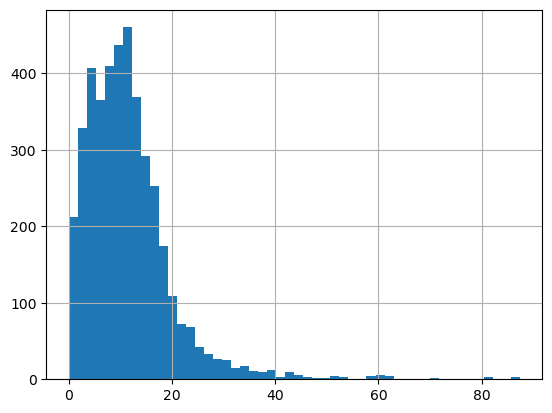

In [31]:
UKM_PS_df["Demand (MVA)"].hist(bins=50)

In [32]:
UKM_PS_df["Demand (MVA)"].median()

10.2584990234375

In [33]:
UKM_PS_df.isna().sum()

PS Name                   0
Firm Capacity (MVA)       0
Demand (MVA)              0
PF                     3116
Geo(Long,Lat)             0
GSP                     336
DNO                       0
dtype: int64